In [413]:
import itertools

import collections
import random

import sklearn.pipeline, sklearn.impute, sklearn.preprocessing
import sklearn.model_selection
import sklearn.ensemble
import sklearn.feature_selection
import sklearn.cluster
import sklearn.decomposition

import numpy as np
import pandas as pd
import pymatgen.symmetry.analyzer
from pymatgen.analysis.local_env import JmolNN
import tqdm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import ase # Needs to be < 3.19.3

In [414]:
RANDOM_SEED = 1234
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tqdm.tqdm.pandas()

In [3]:
dataset_path = "../data_splitting/all_descriptors.pkl"
df = pd.read_pickle(dataset_path)

# Additional Structure Featurization

In [4]:
classes = {
'alkaline' : ['H', 'Li', 'Na', 'K', 'Rb', 'Cs', 'Fr'],
'alkaine_earth' : ['Be', 'Mg', 'Ca', 'Sr', 'Ba', 'Ra'],
'early_transition' : ['Sc', 'Ti', 'V', 'Cr', 'Mn',
                    'Y', 'Zr', 'Nb', 'Mo', 'Tc',
                    'Hf', 'Ta', 'W', 'Re', 'Os'],
'late_transition' : ['Fe', 'Co', 'Ni', 'Cu', 'Zn',
                   'Ru', 'Rh', 'Pd', 'Ag', 'Cd',
                   'Os', 'Ir', 'Pt', 'Au', 'Hg'],
'triel' : ['B', 'Al', 'Ga', 'In', 'Tl'],
'tetrel' : ['C', 'Si', 'Ge', 'Sn', 'Pb'],
'pnictogen' : ['N', 'P', 'As', 'Sb', 'Bi'],
'chalcogen' : ['O', 'S', 'Se', 'Te', 'Po'],
'halide' : ['F', 'Cl', 'Br', 'I', 'At']
}

groups = {}
for key, values in classes.items():
    for val in values:
        groups[val] = key

In [5]:
symbols_cols = collections.Counter()
bond_cols = collections.Counter()
angle_cols = collections.Counter()

neighbor_finder = JmolNN()

with tqdm.tqdm(total=len(df)) as pbar:
    for struct in df["ox_struct"]:
        symbols_cols.update([groups[symbol] for symbol in struct.symbol_set])
        
        for index, site in enumerate(struct.sites):
            connected = [i['site'] for i in neighbor_finder.get_nn_shell_info(struct, index, 1)]
            
            # Bond counts
            for vertex in connected:
                start, end = sorted([groups[str(site.specie.element)], groups[str(vertex.specie.element)]])
                bond = f"{start}-{end}"
                bond_cols[bond] += 0.5
                
            # Angles
            for angle_start, angle_end in map(sorted, itertools.combinations(connected,2)):
                angle = f"{groups[str(angle_start.specie.element)]}-{groups[str(site.specie.element)]}-{groups[str(angle_end.specie.element)]}"
                angle_cols[angle] += 1
        pbar.update(1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [03:35<00:00,  1.80it/s]


In [6]:
tqdm.tqdm.pandas()
all_symbols = set(symbols_cols.keys())
all_bonds = set(bond_cols.keys())
all_angles = set(angle_cols.keys())

def featurize(data):
    symbol_units = "atoms"
    bond_units = "bonds"
    angle_units = "angles"
    struct = data["ox_struct"]
    
    present_symbols = collections.Counter([groups[symbol] for symbol in struct.symbol_set])
    present_bonds = collections.Counter()
    present_angles = collections.Counter()
    
    # Record and Count Symbols
    for symbol, count in present_symbols.items():
        data[f"{symbol} ({symbol_units})"] = count
    data[f"Total Atoms ({symbol_units})"] = sum(present_symbols.values())
    
    for index, site in enumerate(struct.sites):
        connected = [i['site'] for i in neighbor_finder.get_nn_shell_info(struct, index, 1)]
        
        # Count Bonds
        for vertex in connected:
            start, end = sorted([groups[str(site.specie.element)], groups[str(vertex.specie.element)]])
            bond = f"{start}-{end}"
            present_bonds[bond] += 0.5
            
        # Count Angles
        for angle_start, angle_end in map(sorted, itertools.combinations(connected, 2)):
            angle = f"{groups[str(angle_start.specie.element)]}-{groups[str(site.specie.element)]}-{groups[str(angle_end.specie.element)]}"
            present_angles[angle] += 1
            
    # Record Bonds
    for bond, count in present_bonds.items():
        data[f"{bond} ({bond_units})"] = count
    data[f"Total Bonds ({bond_units})"] = sum(present_bonds.values())
            
    # Record Angles
    for angle, count in present_angles.items():
        data[f"{angle} ({angle_units})"] = count
    data[f"Total Angles ({angle_units})"] = sum(present_angles.values())
    
    return data

all_data_features = df.progress_apply(featurize, axis=1)
all_data_features

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [03:39<00:00,  1.77it/s]


,2dm_id (unitless),Total Angles (angles),Total Atoms (atoms),Total Bonds (bonds),alkaine_earth (atoms),alkaine_earth-chalcogen (bonds),alkaine_earth-chalcogen-alkaine_earth (angles),alkaine_earth-chalcogen-alkaline (angles),alkaine_earth-chalcogen-early_transition (angles),alkaine_earth-chalcogen-halide (angles),...,var:num_unfilled,var:num_valance,var:period,var:sound_velocity,var:specific_heat,var:thermal_conductivity,var:vdw_radius,var:vdw_radius_alvarez,var:vdw_radius_mm3,var:vdw_radius_uff
16,2dm-17,102,2,16.0,NaN,NaN,NaN,NaN,NaN,NaN,...,10.888889,0.222222,0.888889,6.537425e+04,0.222181,116.332089,320.888889,1317.555556,213.555556,2440.675556
19,2dm-20,39,2,12.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.836735,1.836735,0.000000,3.309938e+05,0.005760,11250.753474,3.265306,264.489796,90.000000,439.379592
65,2dm-66,0,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,2.000000,0.000000,1.910866e+06,0.150850,796.803200,150.222222,410.888889,107.555556,18.402222
75,2dm-76,116,2,24.0,NaN,NaN,NaN,NaN,NaN,NaN,...,5.000000,0.555556,0.138889,1.365261e+04,0.006067,65.975281,133.472222,451.250000,80.000000,1027.222222
84,2dm-86,36,2,12.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.750000,12.000000,0.000000,3.731840e+05,0.102070,4193.531550,27.000000,300.000000,0.750000,4627.576875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5826,2dm-5837,36,2,12.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.687500,15.187500,0.000000,1.118486e+06,0.092640,1196.402700,67.687500,630.750000,0.187500,3057.616875
5909,2dm-5920,126,3,40.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.966942,9.900826,0.330579,1.960219e+05,0.126204,1025.979337,132.925620,390.429752,190.793388,172.486116
5911,2dm-5922,78,3,36.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.437500,76.000000,1.687500,4.558714e+05,0.070679,11126.452665,239.359375,727.937500,456.109375,749.968594
5936,2dm-5947,0,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Train/Test Split and Clustering

In [7]:
to_fill = [col for col in all_data_features.columns if any([col.endswith('(atoms)'), col.endswith('(bonds)'), col.endswith('(angles)')])]
all_data_features[to_fill] = all_data_features[to_fill].fillna(0)

train, test = sklearn.model_selection.train_test_split(all_data_features, test_size=0.1, random_state=RANDOM_SEED)

In [270]:
import dscribe.descriptors

symbols = range(1,93)

soap = dscribe.descriptors.SOAP(species=symbols,
                                periodic=True,
                                rcut=4,
                                nmax=2,
                                lmax=4)
def saponify(atoms):
    lathered = soap.create(atoms)
    # Soap creates an N x M array
    #     - N is the number of atoms in the system
    #     - M is the size of the SOAP descriptor 
    # So we'll average along the N direction
    rinsed = np.hstack([lathered.mean(axis=0), lathered.min(axis=0), lathered.max(axis=0)])
    return rinsed

In [386]:
cluster_training_data = np.vstack(train['atoms_object (unitless)'].progress_apply(saponify).to_numpy())
print(cluster_training_data.shape)

pca = sklearn.decomposition.PCA(n_components=256)
cluster_training_data = pca.fit_transform(cluster_training_data)
print(cluster_training_data.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 348/348 [00:04<00:00, 75.41it/s]


(348, 255300)
(348, 256)


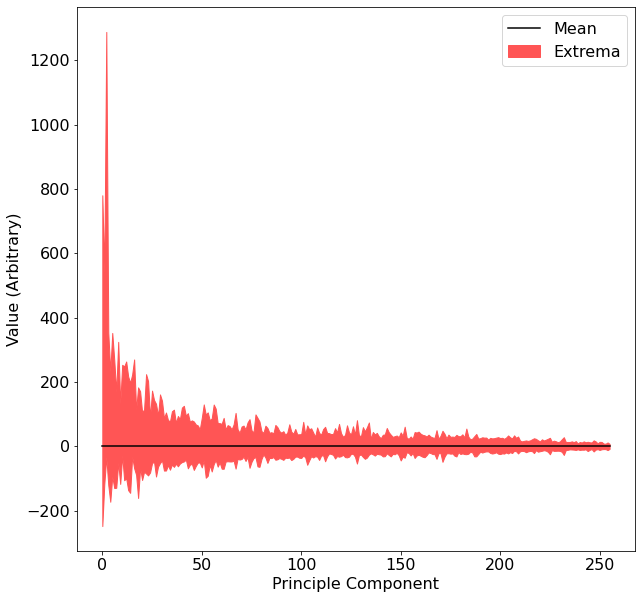

In [396]:
plt.plot(cluster_training_data.mean(axis=0), c='k', label="Mean")
plt.fill_between(range(cluster_training_data.shape[1]), cluster_training_data.min(axis=0), cluster_training_data.max(axis=0), color='#FF5555', label="Extrema")
plt.xlabel("Principle Component")
plt.ylabel("Value (Arbitrary)")
plt.legend()

N_Clusters	Error
2		60.26169947687331
3		71.02927626670206
4		74.0497601616137
5		67.29234914881302
6		67.3861216653172
7		61.467328311954
8		60.267086547330706
9		57.412422461169655
10		53.228696812977574


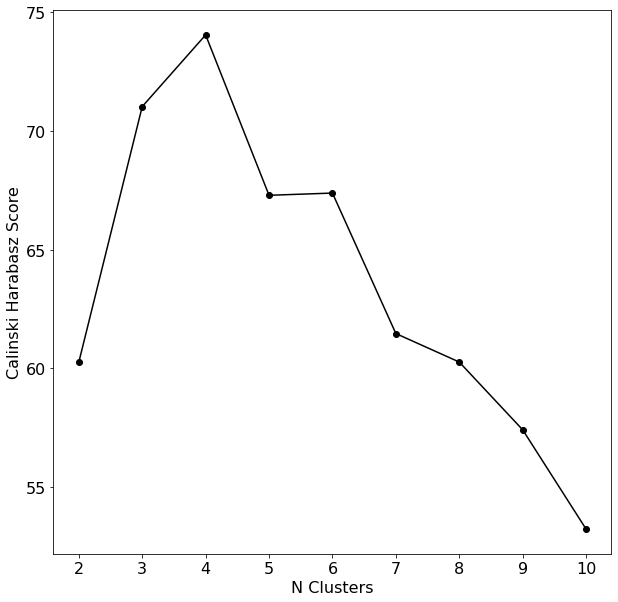

In [412]:
results = {}
min_clusters=2
max_clusters=11
print("N_Clusters\tError")
for n_clusters in range(min_clusters, max_clusters):
    clusters = sklearn.cluster.KMeans(n_clusters=n_clusters,
                                      n_init=16,
                                      random_state=RANDOM_SEED)
    clusters.fit(cluster_training_data)
    error = sklearn.metrics.calinski_harabasz_score(cluster_training_data, clusters.predict(cluster_training_data))
    results[n_clusters] = error
    print(n_clusters, error, sep="\t\t")
    
plt.plot(list(results.keys()), list(results.values()), marker="o", color="black")
plt.xticks(range(min_clusters, max_clusters))
plt.xlabel("N Clusters")
plt.ylabel("Calinski Harabasz Score")
plt.show()

In [404]:
n_clusters = max(results, key=results.get)
print(n_clusters)

clusters = sklearn.cluster.KMeans(n_clusters=n_clusters,
                                  n_init=8,
                                  random_state=RANDOM_SEED)
clusters.fit(cluster_training_data)

labels = collections.Counter(clusters.predict(cluster_training_data))

# We can't actually run SISSO on the dataset if we don't have enough examples for all task labels
while any([count < 4 for count in labels.values()]):
    n_clusters -= 1
    clusters = sklearn.cluster.KMeans(n_clusters=n_clusters,
                                      n_init=8,
                                      random_state=42)
    clusters.fit(cluster_training_data)
    labels = collections.Counter(clusters.predict(cluster_training_data))
print(n_clusters)

4
4


In [405]:
cluster_test = np.vstack(test['atoms_object (unitless)'].progress_apply(saponify).to_numpy())
train['soap_label'] = clusters.predict(cluster_training_data)
test['soap_label'] = clusters.predict(pca.transform(cluster_test))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 67.53it/s]
/var/folders/44/wt0537cs00g919dkdsfqdq8w0000gn/T/ipykernel_58172/2022991764.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['soap_label'] = clusters.predict(pca.transform(cluster_test))


In [406]:
collections.Counter(train['soap_label'])

Counter({3: 21, 1: 51, 2: 47, 0: 229})

In [407]:
collections.Counter(test['soap_label'])

Counter({0: 23, 1: 6, 3: 5, 2: 5})

# Feature Selection

In [256]:
object_cols = ["atoms_object (unitless)",
               "ox_struct"]

regression_irrelevant = object_cols + [
    'discovery_process (unitless)',
    'potcars (unitless)',
    'is_hubbard (unitless)',
    'energy_per_atom (eV)',
    'decomposition_energy (eV/atom)',
    'is_bandgap_direct (unitless)',
    'is_metal (unitless)',
    'energy_vdw_per_atom (eV/atom)',
    'total_magnetization (Bohr Magneton)']

In [268]:
data_train, data_test = sklearn.model_selection.train_test_split(train.drop(columns=regression_irrelevant + ['formula', '2dm_id (unitless)', 'exfoliation_energy_per_atom (eV/atom)']).fillna(0), 
                                                                 test_size=0.1, random_state=RANDOM_SEED)

train_x = data_train.drop(columns=["bandgap (eV)", 'soap_label']).to_numpy()
train_y = data_train["bandgap (eV)"].to_numpy()

val_x = data_test.drop(columns=["bandgap (eV)", 'soap_label']).to_numpy()
val_y = data_test["bandgap (eV)"].to_numpy()

model = sklearn.pipeline.Pipeline(
    [("Scaler", sklearn.preprocessing.MinMaxScaler()),
     ("Ensemble", sklearn.ensemble.RandomForestRegressor(n_estimators = 100, max_features=50))
    ]
)

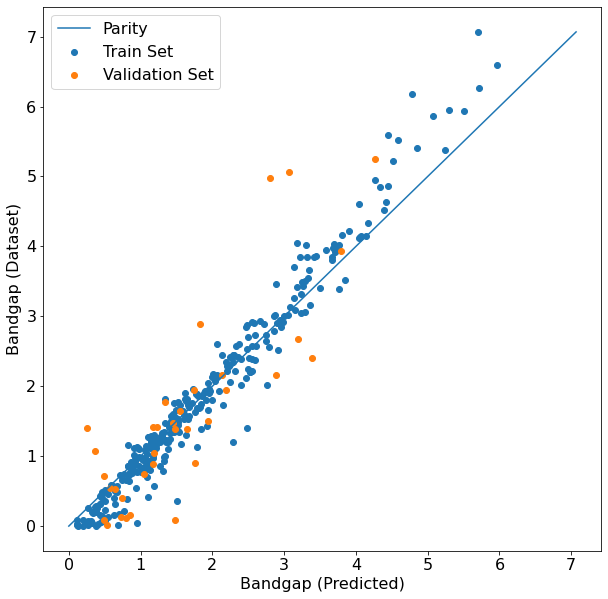

In [269]:
model.fit(X=train_x, y=train_y)

train_y_pred = model.predict(train_x)
val_y_pred = model.predict(val_x)

# Plot the results   
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["font.size"] = 16

plt.scatter(x=train_y_pred, y=train_y, label="Train Set")
plt.scatter(x=val_y_pred, y=val_y, label="Validation Set")
min_xy = min(min(train_y_pred), min(train_y))
max_xy = max(max(train_y_pred), max(train_y))

plt.plot([min_xy,max_xy], [min_xy,max_xy], label="Parity")
plt.ylabel("Bandgap (Dataset)")
plt.xlabel("Bandgap (Predicted)")
plt.legend()
plt.show()

In [259]:
importances = list(sorted(zip(data_train.drop(columns="bandgap (eV)").columns, model[1].feature_importances_), key=lambda i: -i[1]))
importances

[('ave:density', 0.049528056953893076),
 ('max:heat_capacity_mass', 0.030228414502969217),
 ('min:atomic_number', 0.028264348051520182),
 ('ave:boiling_point', 0.024275664757951173),
 ('var:vdw_radius_mm3', 0.022261940936237252),
 ('bond_length_average', 0.022162278322040777),
 ('ave:num_d_valence', 0.014759566256612794),
 ('var:electron_negativity', 0.014087058798808174),
 ('min:num_valance', 0.013078397765099755),
 ('min:fusion_enthalpy', 0.012996446226605278),
 ('ave:period', 0.012965877052330273),
 ('max:melting_point', 0.012665984657785161),
 ('var:en_pauling', 0.012607889156717084),
 ('var:density', 0.011684313141218398),
 ('ave:melting_point', 0.011303105631156066),
 ('var:en_allen', 0.011075165372455049),
 ('min:mendeleev_number', 0.010952270994215408),
 ('min:density', 0.010738152083259652),
 ('min:melting_point', 0.010704536881621662),
 ('min:gs_energy', 0.009989558104229473),
 ('min:c6_gb', 0.009741489609424454),
 ('max:bulk_modulus', 0.009734299977438785),
 ('max:density', 

In [260]:
n_features = 25
importances[:n_features]

[('ave:density', 0.049528056953893076),
 ('max:heat_capacity_mass', 0.030228414502969217),
 ('min:atomic_number', 0.028264348051520182),
 ('ave:boiling_point', 0.024275664757951173),
 ('var:vdw_radius_mm3', 0.022261940936237252),
 ('bond_length_average', 0.022162278322040777),
 ('ave:num_d_valence', 0.014759566256612794),
 ('var:electron_negativity', 0.014087058798808174),
 ('min:num_valance', 0.013078397765099755),
 ('min:fusion_enthalpy', 0.012996446226605278),
 ('ave:period', 0.012965877052330273),
 ('max:melting_point', 0.012665984657785161),
 ('var:en_pauling', 0.012607889156717084),
 ('var:density', 0.011684313141218398),
 ('ave:melting_point', 0.011303105631156066),
 ('var:en_allen', 0.011075165372455049),
 ('min:mendeleev_number', 0.010952270994215408),
 ('min:density', 0.010738152083259652),
 ('min:melting_point', 0.010704536881621662),
 ('min:gs_energy', 0.009989558104229473),
 ('min:c6_gb', 0.009741489609424454),
 ('max:bulk_modulus', 0.009734299977438785),
 ('max:density', 

In [261]:
mutual_information = list(sorted(zip(data_train.drop(columns="bandgap (eV)").columns, sklearn.feature_selection.mutual_info_regression(train_x, train_y)), key=lambda i: -i[1]))
mutual_information

[('max:boiling_point', 0.3616337565739385),
 ('max:bulk_modulus', 0.35074353036857886),
 ('min:mendeleev_number', 0.3387733843226739),
 ('max:melting_point', 0.327792493903333),
 ('min:en_ghosh', 0.31260106334494964),
 ('max:evaporation_heat', 0.3074488253461003),
 ('min:atomic_weight', 0.3037983260840651),
 ('max:vdw_radius_alvarez', 0.3035081497491672),
 ('min:gs_energy', 0.30317899770145784),
 ('min:vdw_radius_uff', 0.3029023993004549),
 ('min:specific_heat', 0.30220324745082827),
 ('var:dipole_polarizability', 0.29427951704631505),
 ('var:mendeleev_number', 0.28976880665223304),
 ('min:gs_est_bcc_latcnt', 0.2841797003568316),
 ('max:dipole_polarizability', 0.28264390916620474),
 ('min:gs_est_fcc_latcnt', 0.28169912394637775),
 ('min:icsd_volume', 0.2782863067907182),
 ('min:num_valance', 0.27648564318024516),
 ('min:en_allen', 0.2745027437420444),
 ('var:evaporation_heat', 0.2700747966802788),
 ('min:vdw_radius', 0.26642047475289843),
 ('min:Polarizability', 0.26528557498682215),
 

In [262]:
mutual_information[:n_features]

[('max:boiling_point', 0.3616337565739385),
 ('max:bulk_modulus', 0.35074353036857886),
 ('min:mendeleev_number', 0.3387733843226739),
 ('max:melting_point', 0.327792493903333),
 ('min:en_ghosh', 0.31260106334494964),
 ('max:evaporation_heat', 0.3074488253461003),
 ('min:atomic_weight', 0.3037983260840651),
 ('max:vdw_radius_alvarez', 0.3035081497491672),
 ('min:gs_energy', 0.30317899770145784),
 ('min:vdw_radius_uff', 0.3029023993004549),
 ('min:specific_heat', 0.30220324745082827),
 ('var:dipole_polarizability', 0.29427951704631505),
 ('var:mendeleev_number', 0.28976880665223304),
 ('min:gs_est_bcc_latcnt', 0.2841797003568316),
 ('max:dipole_polarizability', 0.28264390916620474),
 ('min:gs_est_fcc_latcnt', 0.28169912394637775),
 ('min:icsd_volume', 0.2782863067907182),
 ('min:num_valance', 0.27648564318024516),
 ('min:en_allen', 0.2745027437420444),
 ('var:evaporation_heat', 0.2700747966802788),
 ('min:vdw_radius', 0.26642047475289843),
 ('min:Polarizability', 0.26528557498682215),
 

In [263]:
importants = set([i[0] for i in importances[:n_features]])
mutual_infos = set([i[0] for i in mutual_information[:n_features]])

set.intersection(importants, mutual_infos)

{'max:bulk_modulus',
 'max:melting_point',
 'min:gs_energy',
 'min:mendeleev_number',
 'min:num_valance'}

In [264]:
exported_features = [i[0] for i in importances[:n_features]]
print(exported_features)

['ave:density', 'max:heat_capacity_mass', 'min:atomic_number', 'ave:boiling_point', 'var:vdw_radius_mm3', 'bond_length_average', 'ave:num_d_valence', 'var:electron_negativity', 'min:num_valance', 'min:fusion_enthalpy', 'ave:period', 'max:melting_point', 'var:en_pauling', 'var:density', 'ave:melting_point', 'var:en_allen', 'min:mendeleev_number', 'min:density', 'min:melting_point', 'min:gs_energy', 'min:c6_gb', 'max:bulk_modulus', 'max:density', 'var:atomic_radius_rahm', 'ave:gs_energy']


In [265]:
train_export = train[['bandgap (eV)', 'soap_label'] + exported_features].fillna(0).sort_values('soap_label')
train_export.to_csv('data_train_featurized_soap_importances_bandgap.csv')

In [266]:
test_export = test[['bandgap (eV)', 'soap_label'] + exported_features].fillna(0).sort_values('soap_label')
test_export.to_csv('data_test_featurized_soap_importances_bandgap.csv')